In [1]:
class Point:
    ## Point クラスのコンストラクタ
    # @brief 平面座標の点を生成
    # @param x x座標
    # @param y y座標
    def __init__(self, x, y, data=None):
        self.x = x
        self.y = y
        self.data = data
        
    ## repr 関数
    # @brief オブジェクト自身の返り値指定
    # @return 座標 (x, y)
    def __repr__(self):
        return "<Point {}, {}>".format(self.x, self.y)

In [2]:
class Rectangle:
    ## Rectangle クラスのコンストラクタ
    # @brief 平面座標の点 (x, y) を中心として水平方向に ±w 垂直方向に ±h の四角形を生成
    def __init__(self, x, y, w, h):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
    
    ##  repr 関数
    # @brief オブジェクト自身の返り値指定
    # @return 中心座標と幅と高さ　(x, y, w, h)
    def __repr__(self):
        return "<Rectangle {}, {}, {}, {}>".format(self.x, self.y, self.w, self.h)


    ## 重なりを判定
    # @brief 点との重なりを判定する関数
    # @param p 点
    # @return True/False
    def contains(self, p):
        return p.x >= self.x - self.w and p.x <= self.x + self.w and p.y >= self.y - self.h and p.y <= self.y + self.h

    ## 交差判定
    # @brief 四角形との重なりを判定
    # @param r 　四角形
    # @return True/False
    def intersects(self, r):
        return not (self.x - r.w > self.x + self.w or r.x + r.w < self.x - self.w or r.y - r.h > self.y + self.h or r.y + r.h < self.y - self.h)

In [3]:
class QuadTree:
    ## コンストラクタ
    # @berief 四分木クラスのコンストラクタ
    # @param boundary 境界四角形
    # @param capacity 四分木の頂点容量の上限
    def __init__(self, boundary, capacity):
        if not boundary:
            raise TypeError('boundary is null or undefined')
        
        if not isinstance(boundary, Rectangle):
            raise TypeError('boundary should be a Rectangle')
        
        if not isinstance(capacity, int):
            raise TypeError('capacity should be a number but is a {}'.format(type(capacity)))
        
        if capacity < 0:
            raise RangeError('capacity must be greater than 0')
        
        self.boundary = boundary
        self.capacity = capacity
        self.points = []
        self.divided = False
        
    ## 分割操作
    # @brief 四分木の境界領域を4分割する関数
    def subdivide(self):
        x = self.boundary.x
        y = self.boundary.y
        w = self.boundary.w / 2
        h = self.boundary.h / 2

        ne = Rectangle(x + w, y - h, w, h)
        self.northeast = QuadTree(ne, self.capacity)
        nw = Rectangle(x - w, y - h, w, h)
        self.northwest = QuadTree(nw, self.capacity)
        se = Rectangle(x + w, y + h, w, h)
        self.southeast = QuadTree(se, self.capacity)
        sw = Rectangle(x - w, y + h, w, h)
        self.southwest = QuadTree(sw, self.capacity)

        self.divided = True
    
    
    # 挿入操作
    # @brief 四分木に点を挿入する関数
    # @param p 点
    # @return 挿入に成功したとき True
    def insert(self, p):
        if not self.boundary.contains(p):
            return False

        if len(self.points) < self.capacity:
            self.points.append(p)
            return True

        if not self.divided:
            self.subdivide()

        return self.northeast.insert(p) or self.northwest.insert(p) or self.southeast.insert(p) or self.southwest.insert(p)
    
    
    ## クエリ操作
    # @brief 指定した領域と重なる点を返す関数
    # @param r 四角形領域
    # @param found 
    def query(self, r, found=None):
        if found is None:
            found = []

        if not r.intersects(self.boundary):
            return found

        for p in self.points:
            if r.contains(p):
                found.append(p)
        if self.divided:
            self.northwest.query(r, found)
            self.northeast.query(r, found)
            self.southwest.query(r, found)
            self.southeast.query(r, found)

        return found

In [4]:
import numpy as np

# データ生成
X = np.random.random((100, 2)) ** 0.5

# 四分木の作成、点の挿入
boundary = Rectangle(0.5, 0.5, 0.5, 0.5)
qtree = QuadTree(boundary, 4);
_ = [qtree.insert(Point(*x)) for x in X]

In [5]:
# 四分木の確認
print(qtree.divided)
print(qtree.northeast.boundary)
print(qtree.northwest.boundary)
print(qtree.southeast.boundary)
print(qtree.southwest.boundary)

True
<Rectangle 0.75, 0.25, 0.25, 0.25>
<Rectangle 0.25, 0.25, 0.25, 0.25>
<Rectangle 0.75, 0.75, 0.25, 0.25>
<Rectangle 0.25, 0.75, 0.25, 0.25>


In [6]:
# クエリの発行
r = Rectangle(-0.1, -0.1, 0.5, 0.5)
print(r.x, r.y, r.w, r.h)
qtree.query(r)

-0.1 -0.1 0.5 0.5


[<Point 0.18968667566247957, 0.20843793331055707>,
 <Point 0.22052732802523783, 0.38770805077685744>,
 <Point 0.08741929482719497, 0.19649106665763874>,
 <Point 0.15473136555499228, 0.2761870291652513>]

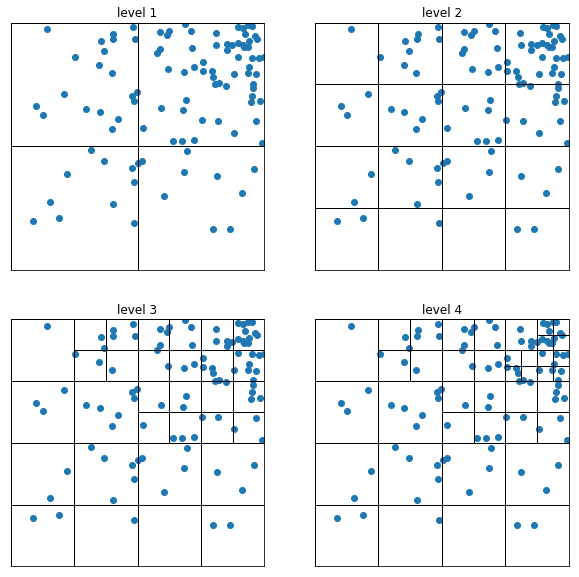

In [7]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
from numpy.random import randn

import matplotlib.patches as patches

# 新規のウィンドウを描画
fig = plt.figure(figsize=(10,10))

# サブプロットを追加
ax_list = [fig.add_subplot(2,2,i+1, xticks=[], yticks=[]) for i in range(4)]

# 散布図
[ax.scatter(X[:, 0], X[:, 1]) for ax in ax_list]

# 描画範囲指定
[ax.set_xlim([0, 1]) for ax in ax_list]
[ax.set_ylim([0, 1]) for ax in ax_list]

# 四分木の描画関数
def plot_qtree(qt, ax, depth=float('inf')):
    x = qt.boundary.x
    y = qt.boundary.y
    w = qt.boundary.w
    h = qt.boundary.h
    rect = plt.Rectangle(
        xy=(x-w, y-h), 
        width=w*2, 
        height=h*2, 
        ec='#000000', fill=False)
    ax.add_patch(rect)
    if qt.divided and depth>0:
        depth -= 1
        plot_qtree(qt.northeast, ax, depth)
        plot_qtree(qt.northwest, ax, depth)
        plot_qtree(qt.southeast, ax, depth)
        plot_qtree(qt.southwest, ax, depth)

#  四分木の描画
[plot_qtree(qtree, ax_list[i], i+1) for i in range(4)]

# タイトル
[ax_list[i].set_title('level {}'.format(i+1)) for i in range(4)]

plt.show()